In [67]:
%reload_ext autoreload
%autoreload
%matplotlib inline

In [68]:
from fastai.tabular import *

In [69]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad, use_variance=True, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

In [70]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [71]:
path = Path('')

In [72]:
path.ls()

[PosixPath('Economic Data and Recession Odds.ipynb'),
 PosixPath('Data Cleaning Functions.ipynb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('Economic Data and 12 Month SP Return.ipynb'),
 PosixPath('Economic Data and Fed Funds.ipynb'),
 PosixPath('models'),
 PosixPath('Market Model_12monthSP - Sheet1.csv')]

In [73]:
df = pd.read_csv(path/'Market Model_12monthSP - Sheet1.csv')

In [74]:
df.shape

(331, 193)

In [75]:
df.head()

,date,0_consumerdiscretionary,0_informationtechnology,0_healthcare,0_energy,0_utilities,0_industrials,0_materials,0_realestate,0_financials,...,jp_neworders,jp_unemploymentrate,jp_manufacturing,jp_servicespmi,jp_manufacturingpmi,jp_10yr,jp_gdpgrowth,decision,12mospreturn,recession
0,1/1/1992,NaN,1.607510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1300.22,2.1,-3.8,NaN,NaN,5.449,0.0,lower,0.075734,no
1,2/1/1992,NaN,1.727698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1301.16,2.0,-4.5,NaN,NaN,5.578,0.0,lower,0.103481,no
2,3/1/1992,NaN,1.547416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1291.57,2.1,-5.4,NaN,NaN,5.531,0.0,lower,0.106848,no
3,4/1/1992,NaN,1.622534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1323.94,2.1,-5.8,NaN,NaN,5.710,0.4,lower,0.150718,no
4,5/1/1992,NaN,1.442252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1161.37,2.1,-9.1,NaN,NaN,5.739,0.4,hold,0.098756,no


In [76]:
add_datepart(df, "date", drop=False)

In [77]:
df.head()

,date,0_consumerdiscretionary,0_informationtechnology,0_healthcare,0_energy,0_utilities,0_industrials,0_materials,0_realestate,0_financials,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1992-01-01,NaN,1.607510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2,1,False,True,False,True,False,True,694224000
1,1992-02-01,NaN,1.727698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,5,32,False,True,False,False,False,False,696902400
2,1992-03-01,NaN,1.547416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,6,61,False,True,False,False,False,False,699408000
3,1992-04-01,NaN,1.622534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,2,92,False,True,False,True,False,False,702086400
4,1992-05-01,NaN,1.442252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,4,122,False,True,False,False,False,False,704678400


### Classification

In [124]:
dep_var = '3_nonfarmpayrolls'
cat_names = ['recession', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed']
cont_names = ["1_fedfundsrate", '0_consumerdiscretionary', '0_informationtechnology', '0_healthcare', '0_energy', '0_utilities', '0_industrials', '0_materials', '0_realestate', '0_financials', '0_consumerstaples', '0_russell', '0_nasdaq', '0_speps', '0_amzn', '0_wmt', '0_spperatio', '0_spearnings', '0_spdividends', '0_spcape', '1_dollarindex', '1_2yearmaturity', '1_aaacorpbondto10year', '1_policyu', '1_ltyield', '1_vix', '1_gold', '1_baacorptotreas', '1_90dayeurodollar', '1_spreturn', '1_libor', '1_eurusd', '1_tenyearthreemonth', '1_tedspread', '1_fedfundsrate', '1_nyfedrprob', '1_10yr2yr', '1_copperprice', '2_gdpgrowthyoy','3_unemployment', '3_longtermunemployment', '3_participationrate', '3_participationrateworkingage', '3_employmenttopopulationrate', '3_parttimeworkers', '3_initialclaimsaverage', '3_continuingclaims', '3_govtpayrolls', '3_nonfarmprivatepayrolls', '3_manufacturingpayrolls', '3_joboffers', '3_wages', '3_wagegrowth', '3_wagesinmanufacturing', '3_avghourlyearnings', '3_avgweeklyhours', '3_challengerjobcuts', '3_jobvacancies', '3_youthunemployment', '4_inflation', '4_inflationexpectations', '4_cpi', '4_coreinflationrate', '4_producerpricechanges', '4_exportprices', '4_importprices', '4_foodinflation', '4_corepceindex', '4_coreproduceprices', '4_cpihousingutilities', '4_cpitransportation', '4_pcepriceindex', '4_uscassfreightshipments', '4_uscassfreightexpenditures', '4_longbeachinbound', '4_longbeachoutbound', '4_longbeachempties', '4_trucktonnage', '4_freighttransportindex', '4_railfreightcarloads', '4_railfreightintermodal', '5_mo', '5_m1', '5_m2', '5_velocityofm1', '5_velocityofm2', '5_fxreserves', '5_loanstoprivatesector', '5_foreignbondinvestment', '5_loansttoprivatesector', '5_fdiintous', '6_balanceoftrade', '6_exports', '6_imports', '6_capital flows', '6_longtermticflows', '6_crudeoilproduction', '6_crudeoilprices', '6_goodstradebalance', '6_tourismrevenues', '6_touristarrivals', '7_monthstopotuselection', '7_debttogdp', '7_govtspending', '8_uspmi', '8_markitpmi', '8_industrialproduction', '8_manufacturingproduction', '8_capacityutilization', '8_us_durablegoods', '8_durablegoodsexdefense', '8_durablegoodsextransportation', '8_factoryordersextransportation', '8_factoryorders', '8_neworders', '8_businessinventories', '8_wholesaleinventories', '8_nfibbusinessoptimismindex', '8_chicagofedactivityindex', '8_dallasfedmanufacturingindex', '8_nyempiremanfacturingindex', '8_phillyfedindex', '8_richmondfedindex', '8_autoassemblies', '8_lightvehiclesales', '8_leadingindex', '8_kansascityfedindex', '8_miningproduction', '8_steelproduction', '8_capitalgoodsshipments', '8_capitalgoodsorders', '8_rvannualyoy', '8_corporateprofits', '8_bankruptcies', '9_consumersentiment', '9_advanceretailsales', '9_retailsales', '9_retailsalesyoy', '9_retailsalesexautos', '9_disppersonalincome', '9_consumerspending', '9_personalspending', '9_personalincome', '9_personalsavings', '9_consumercredit', '9_privatesectorcredit', '9_banklendingrate', '9_ibdtippeconomicoptimismindex', '9_chainstoresales', '9_gasolineprices', '9_householddebttoincome', '10_caseindex', '10_housingstartssingle', '10_housingstartsmulti', '10_buildingpermits', '10_newhomesales', '10_pendinghomesales', '10_existinghomesales', '10_constructionnonres', '10_housingindex', '10_nahbhousingindex', '11_oecdbizconditions', '11_eurgovtbondyields', '11_euro_servicespmi', '11_euro_manufacturingpmi', '11_eurogdpgrowth', 'ger_ltyields', 'ger_3month', 'ger_unemp', 'ger_industrialprod', 'ger_neworders', 'ger_servicespmi', 'ger_manufacturingpmi', 'ger_gdpgrowth', 'ch_industrialprod', 'ch_electric', 'ch_consumerconf', 'ch_compositepmi', 'ch_caixinpmi', 'ch_gdpgrowth', 'jp_industrialprod', 'jp_neworders', 'jp_unemploymentrate', 'jp_manufacturing', 'jp_servicespmi', 'jp_manufacturingpmi', 'jp_10yr', 'jp_gdpgrowth','2_gdpgrowth']
procs = [FillMissing, Categorify, Normalize]

In [125]:
valid_idx = range(len(df)-125, len(df)-5)
valid_idx

range(206, 326)

In [126]:
test = TabularList.from_df(df.iloc[326:331].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [127]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx)
                           .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                           .add_test(test)
                           .databunch())

In [128]:
data.show_batch(rows=5)


recession,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,0_consumerdiscretionary_na,0_healthcare_na,0_energy_na,0_utilities_na,0_industrials_na,0_materials_na,0_realestate_na,0_financials_na,0_consumerstaples_na,0_russell_na,0_speps_na,0_amzn_na,0_spperatio_na,0_spearnings_na,0_spdividends_na,3_joboffers_na,3_wagegrowth_na,3_avghourlyearnings_na,3_avgweeklyhours_na,3_challengerjobcuts_na,3_jobvacancies_na,4_inflation_na,4_inflationexpectations_na,4_cpi_na,4_coreproduceprices_na,4_uscassfreightshipments_na,4_uscassfreightexpenditures_na,4_longbeachinbound_na,4_longbeachoutbound_na,4_longbeachempties_na,4_trucktonnage_na,4_freighttransportindex_na,4_railfreightcarloads_na,4_railfreightintermodal_na,5_velocityofm1_na,5_velocityofm2_na,5_fdiintous_na,6_balanceoftrade_na,6_exports_na,6_imports_na,6_capital flows_na,6_longtermticflows_na,6_crudeoilproduction_na,6_crudeoilprices_na,6_goodstradebalance_na,6_tourismrevenues_na,6_touristarrivals_na,7_debttogdp_na,7_govtspending_na,8_markitpmi_na,8_us_durablegoods_na,8_durablegoodsexdefense_na,8_durablegoodsextransportation_na,8_factoryordersextransportation_na,8_factoryorders_na,8_neworders_na,8_businessinventories_na,8_wholesaleinventories_na,8_chicagofedactivityindex_na,8_dallasfedmanufacturingindex_na,8_nyempiremanfacturingindex_na,8_phillyfedindex_na,8_richmondfedindex_na,8_leadingindex_na,8_kansascityfedindex_na,8_steelproduction_na,8_capitalgoodsshipments_na,8_capitalgoodsorders_na,8_corporateprofits_na,8_bankruptcies_na,9_consumersentiment_na,9_retailsales_na,9_retailsalesyoy_na,9_retailsalesexautos_na,9_disppersonalincome_na,9_consumerspending_na,9_personalspending_na,9_personalincome_na,9_personalsavings_na,9_consumercredit_na,9_ibdtippeconomicoptimismindex_na,9_chainstoresales_na,9_householddebttoincome_na,10_caseindex_na,10_newhomesales_na,10_pendinghomesales_na,10_constructionnonres_na,10_housingindex_na,11_euro_servicespmi_na,11_euro_manufacturingpmi_na,11_eurogdpgrowth_na,ger_industrialprod_na,ger_neworders_na,ger_servicespmi_na,ger_manufacturingpmi_na,ger_gdpgrowth_na,ch_electric_na,ch_consumerconf_na,ch_compositepmi_na,ch_caixinpmi_na,ch_gdpgrowth_na,jp_industrialprod_na,jp_neworders_na,jp_unemploymentrate_na,jp_manufacturing_na,jp_servicespmi_na,jp_manufacturingpmi_na,jp_gdpgrowth_na,1_fedfundsrate,0_consumerdiscretionary,0_informationtechnology,0_healthcare,0_energy,0_utilities,0_industrials,0_materials,0_realestate,0_financials,0_consumerstaples,0_russell,0_nasdaq,0_speps,0_amzn,0_wmt,0_spperatio,0_spearnings,0_spdividends,0_spcape,1_dollarindex,1_2yearmaturity,1_aaacorpbondto10year,1_policyu,1_ltyield,1_vix,1_gold,1_baacorptotreas,1_90dayeurodollar,1_spreturn,1_libor,1_eurusd,1_tenyearthreemonth,1_tedspread,1_fedfundsrate,1_nyfedrprob,1_10yr2yr,1_copperprice,2_gdpgrowthyoy,3_unemployment,3_longtermunemployment,3_participationrate,3_participationrateworkingage,3_employmenttopopulationrate,3_parttimeworkers,3_initialclaimsaverage,3_continuingclaims,3_govtpayrolls,3_nonfarmprivatepayrolls,3_manufacturingpayrolls,3_joboffers,3_wages,3_wagegrowth,3_wagesinmanufacturing,3_avghourlyearnings,3_avgweeklyhours,3_challengerjobcuts,3_jobvacancies,3_youthunemployment,4_inflation,4_inflationexpectations,4_cpi,4_coreinflationrate,4_producerpricechanges,4_exportprices,4_importprices,4_foodinflation,4_corepceindex,4_coreproduceprices,4_cpihousingutilities,4_cpitransportation,4_pcepriceindex,4_uscassfreightshipments,4_uscassfreightexpenditures,4_longbeachinbound,4_longbeachoutbound,4_longbeachempties,4_trucktonnage,4_freighttransportindex,4_railfreightcarloads,4_railfreightintermodal,5_mo,5_m1,5_m2,5_velocityofm1,5_velocityofm2,5_fxreserves,5_loanstoprivatesector,5_foreignbondinvestment,5_loansttoprivatesector,5_fdiintous,6_balanceoftrade,6_exports,6_imports,6_capital flows,6_longtermticflows,6_crudeoilproduction,6_crudeoilprices,6_goodstradebalance,6_tourismrevenues,6_touristarrivals,7_monthstopotu

In [ ]:
learn = tabular_learner(data, layers=[800,200], ps=[0.001,0.01], emb_drop=0.04, metrics=exp_rmspe, opt_func=RAdam)

In [130]:
learn.model;

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


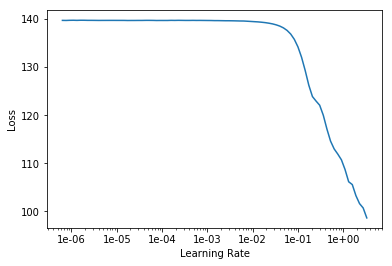

In [131]:
learn.lr_find()
learn.recorder.plot()

In [146]:
learn.fit_one_cycle(10, 5e-1, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,52.707100,39.834999,0.998042,00:00
1,43.579685,4.447092,0.846235,00:00
2,29.967470,35.823189,2996.429688,00:00
3,23.738970,0.769866,0.570882,00:00
4,19.248423,7.133731,0.930271,00:00
5,16.995167,3.622742,0.847728,00:00
6,14.441672,0.123521,0.294374,00:00
7,12.241885,0.021538,0.151566,00:00
8,10.541141,0.042867,0.222078,00:00
9,9.188984,0.040486,0.214529,00:00


In [147]:
row = df.iloc[330]

In [148]:
learn.predict(row)

(FloatItem [11.919363], tensor([11.9194]), tensor([11.9194]))

In [149]:
outcome = np.exp(11.919363)
outcome

150145.9349822941

In [150]:
test_preds=learn.get_preds(DatasetType.Test)

In [151]:
test_preds

[tensor([[11.9666],
         [11.9432],
         [11.9630],
         [11.9643],
         [11.9194]]), tensor([0, 0, 0, 0, 0])]